# DMD on signals with low + medium + fast temporal frequencies

In [1]:
from pydmd import BOPDMD
from pydmd.preprocessing import hankel_preprocessing
from pydmd.plotter import plot_summary
from signal_generator import SignalGenerator
from matplotlib import pyplot as plt
import numpy as np

Generate the signal on which DMD will be performed. This signal is the superposition of six sinusoids with very different frequencies (two low frequencies, two medium frequencies and two fast frequencies), plus some noise.

In [2]:
signal_generator = SignalGenerator(t_length=36)
signal_generator.add_signal("all")
signal_generator.add_noise(noise_std=0.1, random_seed=42)

Plot the six sinusoids plus the resulting signal

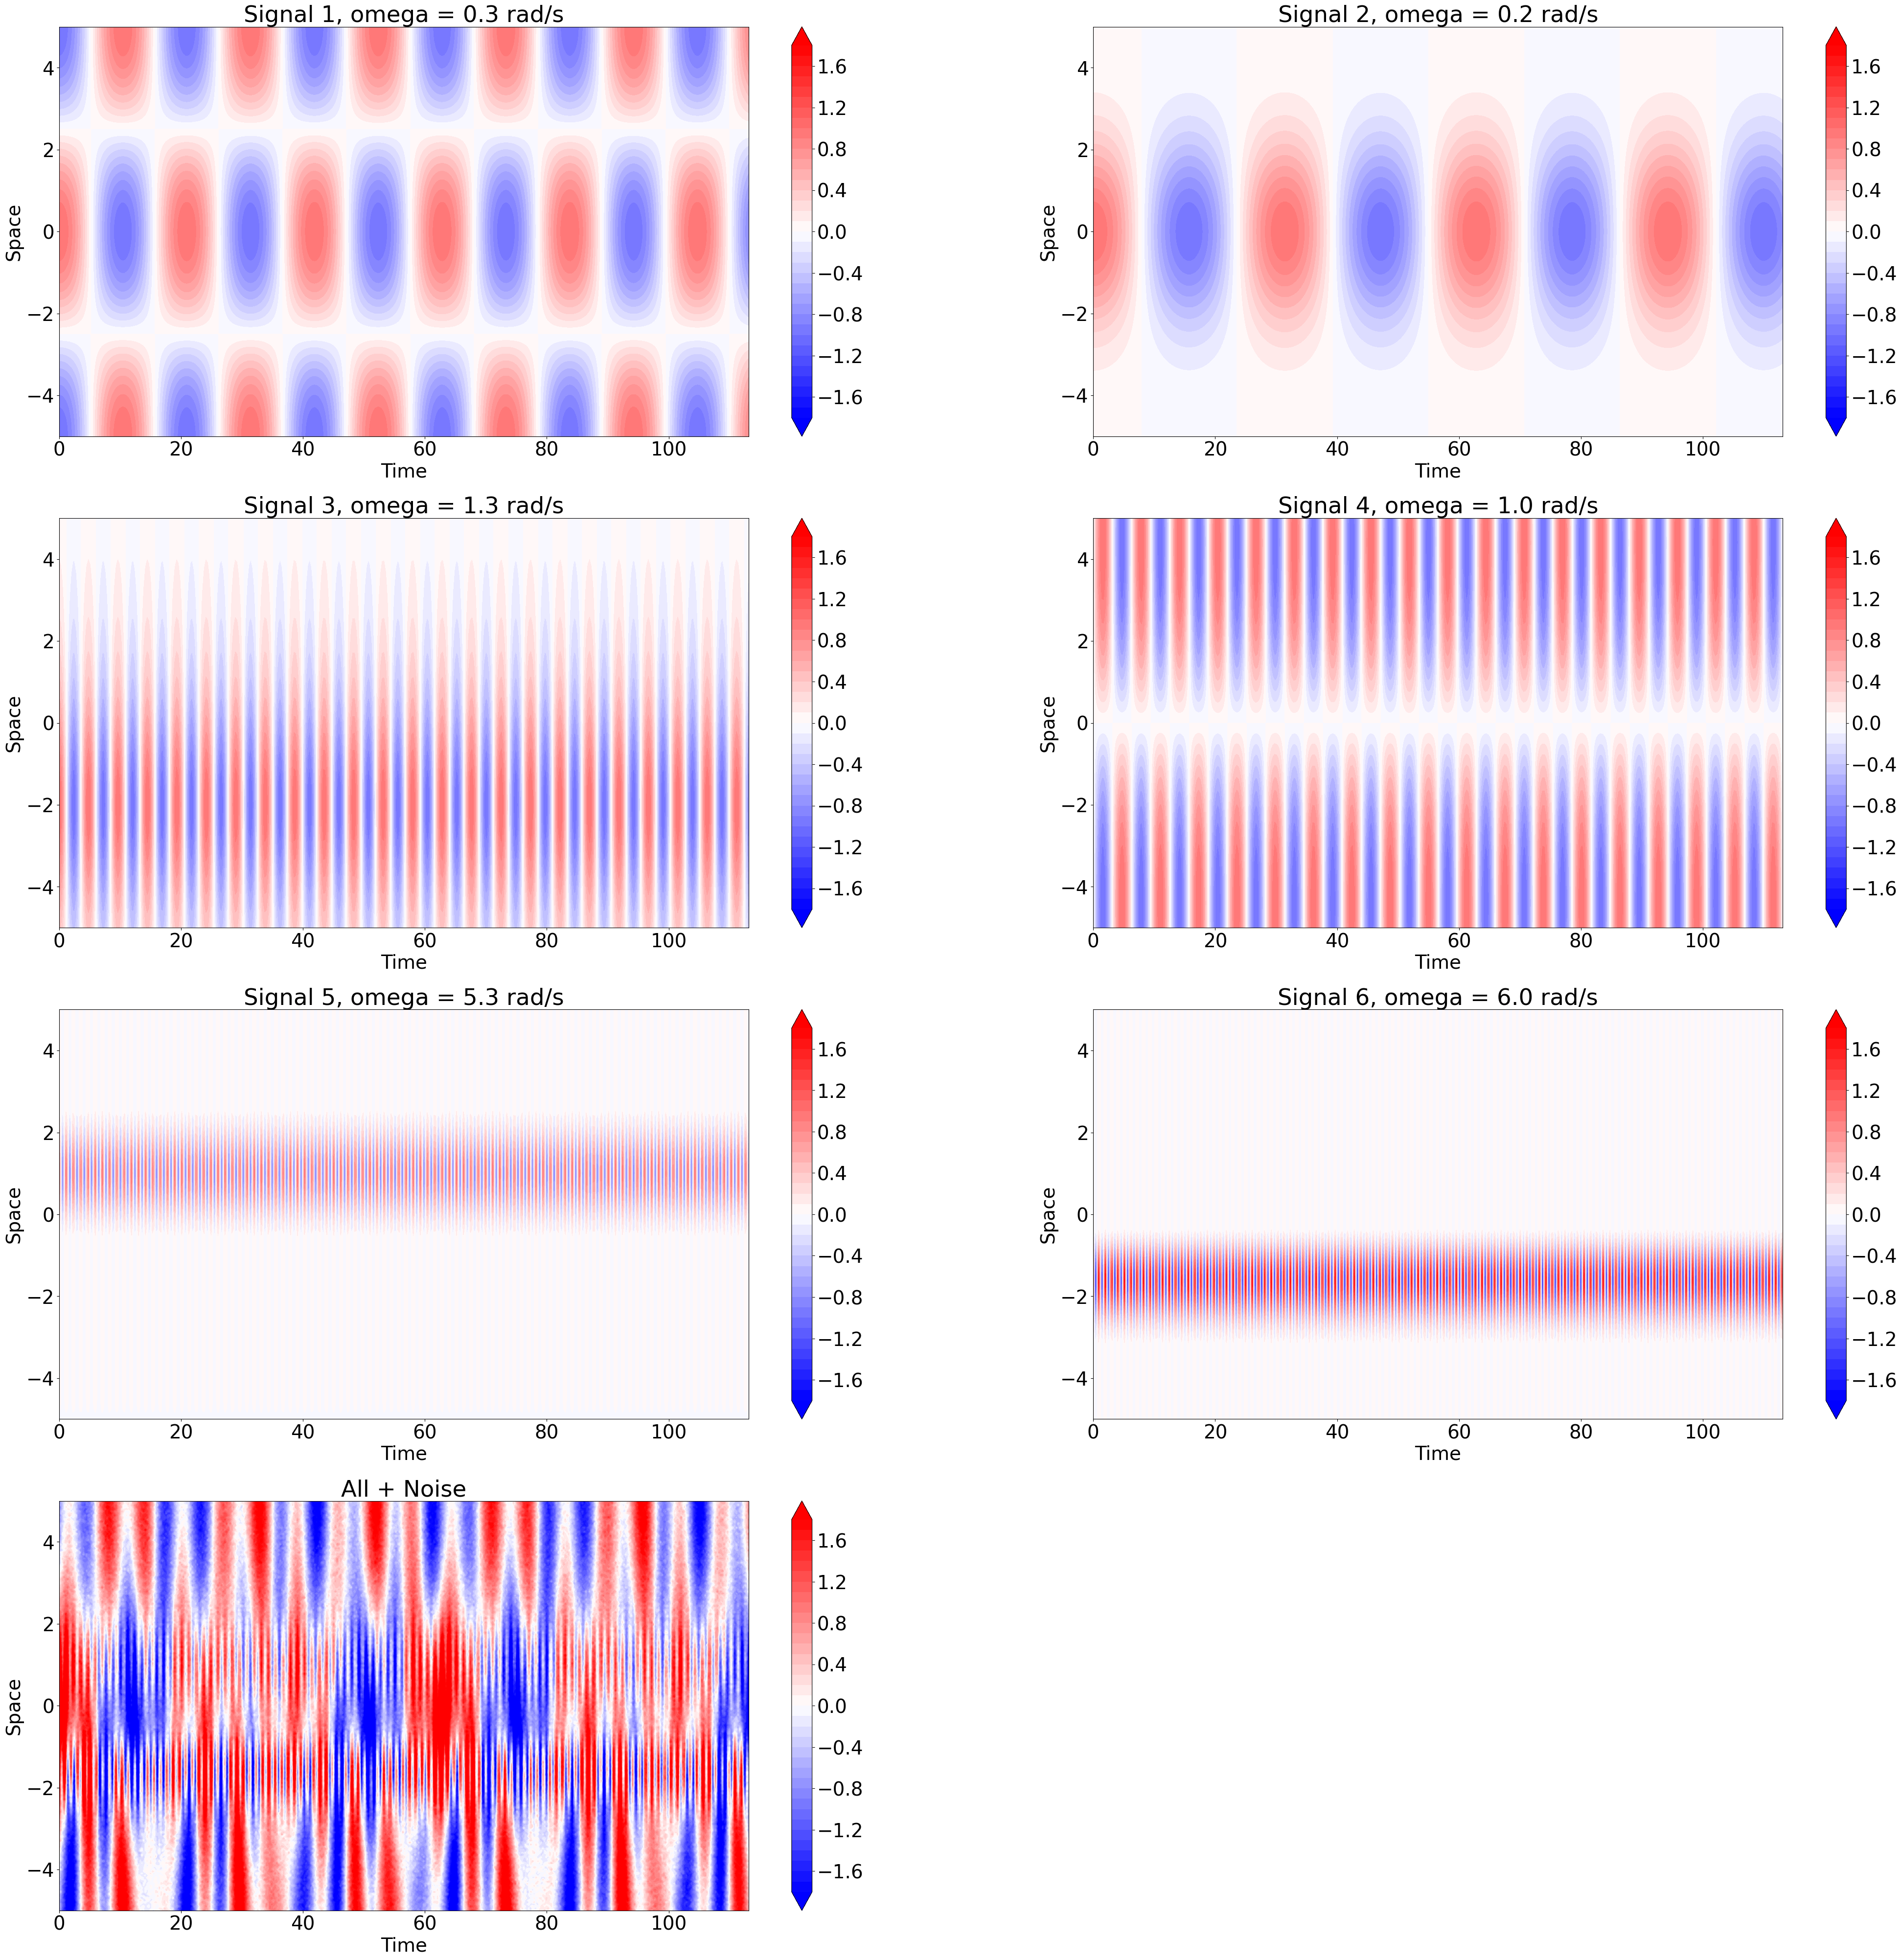

In [3]:
plt.rcParams.update({'font.size': 28})

fig = plt.figure(figsize=(50, 50))

vmin = -1.8; vmax = 1.8
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(4, 2, 1)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f1_slow, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 1, omega = {signal_generator.omega_f1slow} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 2)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f2_slow, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 2, omega = {signal_generator.omega_f2slow} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 3)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f1_med, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 3, omega = {signal_generator.omega_f1med} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 4)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f2_med, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 4, omega = {signal_generator.omega_f2med} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 5)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f1_fast, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 5, omega = {signal_generator.omega_f1fast} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 6)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f2_fast, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title(f'Signal 6, omega = {signal_generator.omega_f2fast} rad/s')
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(4, 2, 7)
contour = ax.contourf(signal_generator.T, signal_generator.X, signal_generator.f, levels=levels, cmap='bwr', extend='both')
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('All + Noise')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

Perform optimized DMD using the BOPDMD class

In [4]:
svd_rank = 12  # the signal is composed of 6 distinct modes, so we need 2 DMD eigenvalues for each oscillation
delay = 2  # need time delay embedding to be able to recover the proper rank structure
optdmd = BOPDMD(svd_rank=svd_rank, num_trials=0)
delay_optdmd = hankel_preprocessing(optdmd, d=delay)

In [5]:
# fit DMD model to 80% of the data, save the rest for testing
train_frac = 0.8
f_train = signal_generator.f[:int(train_frac * signal_generator.f.shape[0]), :]
t_train = signal_generator.t[:int(train_frac * signal_generator.f.shape[0])]
f_test = signal_generator.f[int(train_frac * signal_generator.f.shape[0]):, :]
t_test = signal_generator.t[int(train_frac * signal_generator.f.shape[0]):]

In [6]:
t_delay = t_train[:-delay+1]
delay_optdmd.fit(f_train.T, t=t_delay)

/Users/dsalvadorjasin/Documents/projects/MetOffice/DMD/toy_dataset/.venv/lib/python3.10/site-packages/pydmd/bopdmd.py:751: UserWarning: Initial trial of Optimized DMD failed to converge. Consider re-adjusting your variable projection parameters with the varpro_opts_dict and consider setting verbose=True.
  warnings.warn(msg)


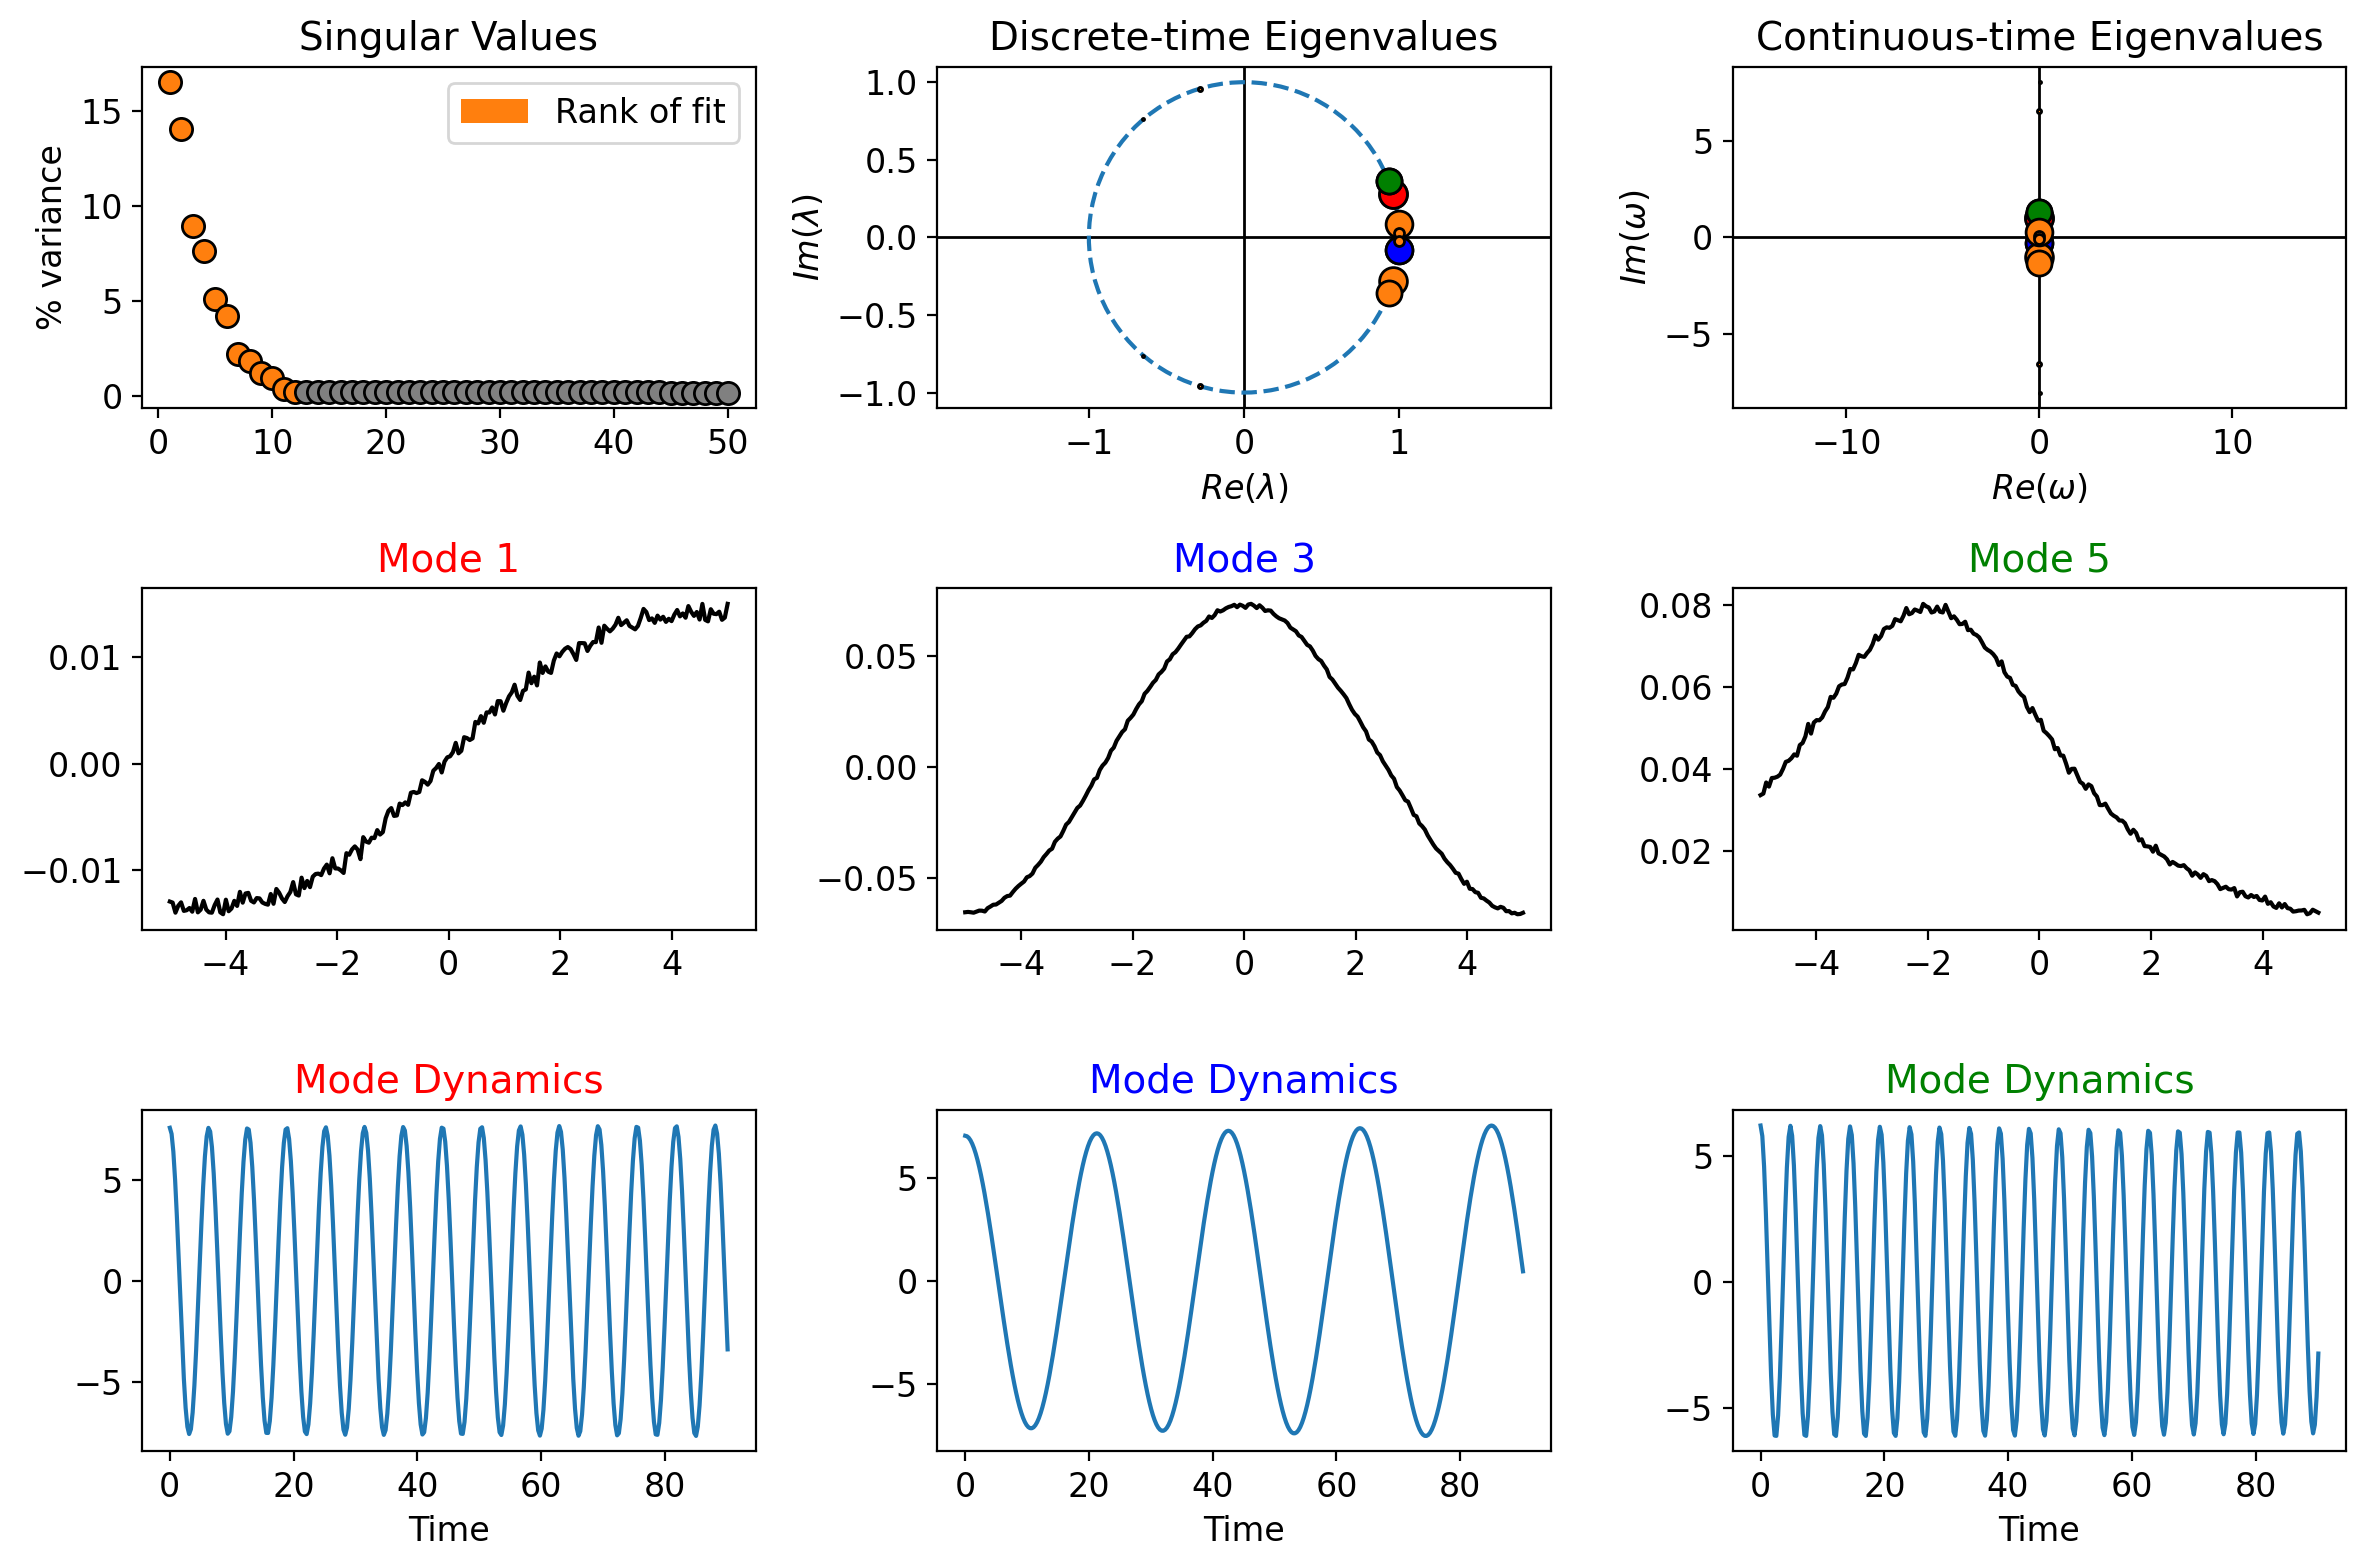

In [7]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [8]:
# sort by decreasing amplitude
sorted_index = np.argsort(np.abs(delay_optdmd.amplitudes))[::-1]
delay_optdmd.eigs[sorted_index]

array([ 0.0001777 +0.99837317j,  0.0001777 -0.99837317j,
        0.00079968-0.2955354j ,  0.00079968+0.2955354j ,
       -0.00037028+1.3015345j , -0.00037028-1.3015345j ,
       -0.00114737+0.09031625j, -0.00114737-0.09031625j,
       -0.00434179-6.56755665j, -0.00434179+6.56755665j,
        0.01038332+8.04085174j,  0.01038332-8.04085174j])

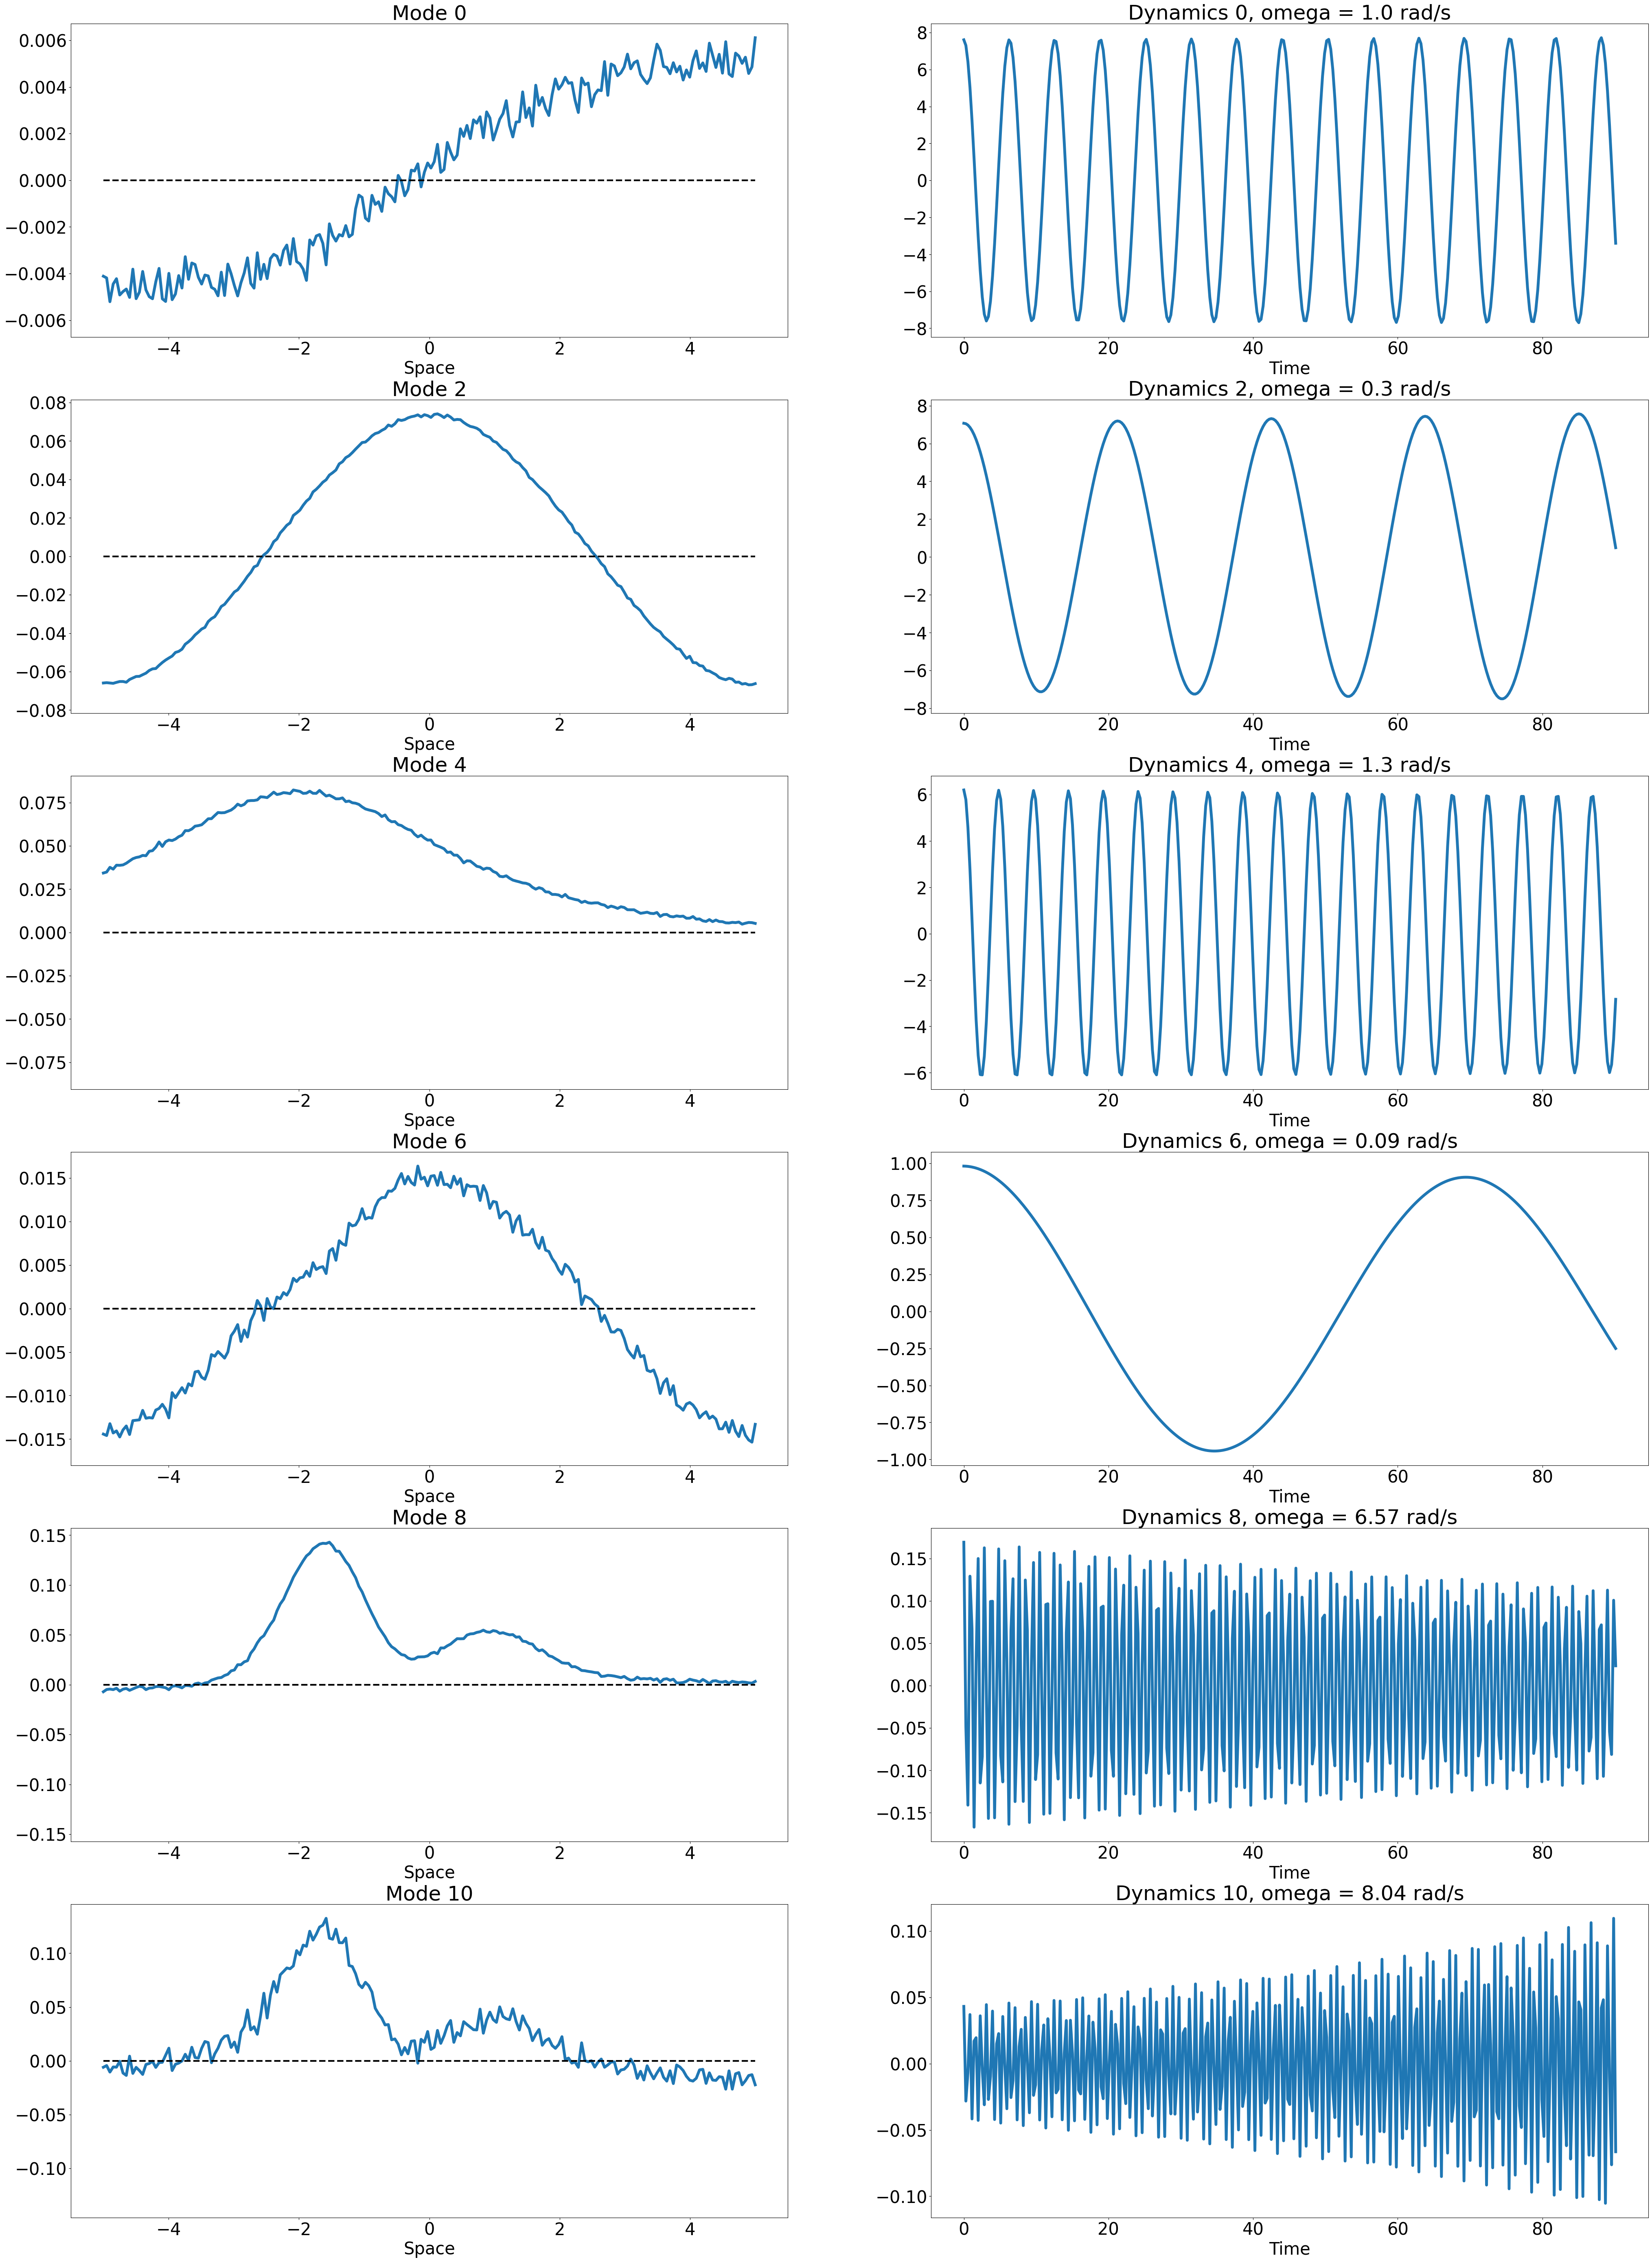

In [9]:
# plot the spatial modes and their dynamics

plt.rcParams.update({'font.size': 30})

which_modes = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(6, 2, figsize=(50, 70))
axs = axs.flatten()

eigs = delay_optdmd.eigs[sorted_index]
modes = delay_optdmd.modes[:, sorted_index]
dynamics = delay_optdmd.dynamics[sorted_index, :]

for i, mode in enumerate(which_modes):
    axs[2*i].plot(signal_generator.x, modes[:signal_generator.x.shape[0], mode].real, linewidth=5)
    axs[2*i].set_title(f'Mode {mode}')
    axs[2*i].set_xlabel('Space')
    max_val = np.max(np.abs(modes[:signal_generator.x.shape[0], mode].real))
    axs[2*i].set_ylim([-max_val*1.1, max_val*1.1])
    axs[2*i].hlines(0, signal_generator.x[0], signal_generator.x[-1], color='k', linestyle='--', linewidth=3)

    axs[2*i+1].plot(t_delay, dynamics[mode, :].real, linewidth=5)
    axs[2*i+1].set_title(f'Dynamics {mode}, omega = {np.round(np.abs(eigs[mode].imag), 2)} rad/s')
    axs[2*i+1].set_xlabel('Time')

plt.show()


Perform a forecast using the opt DMD model

In [10]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

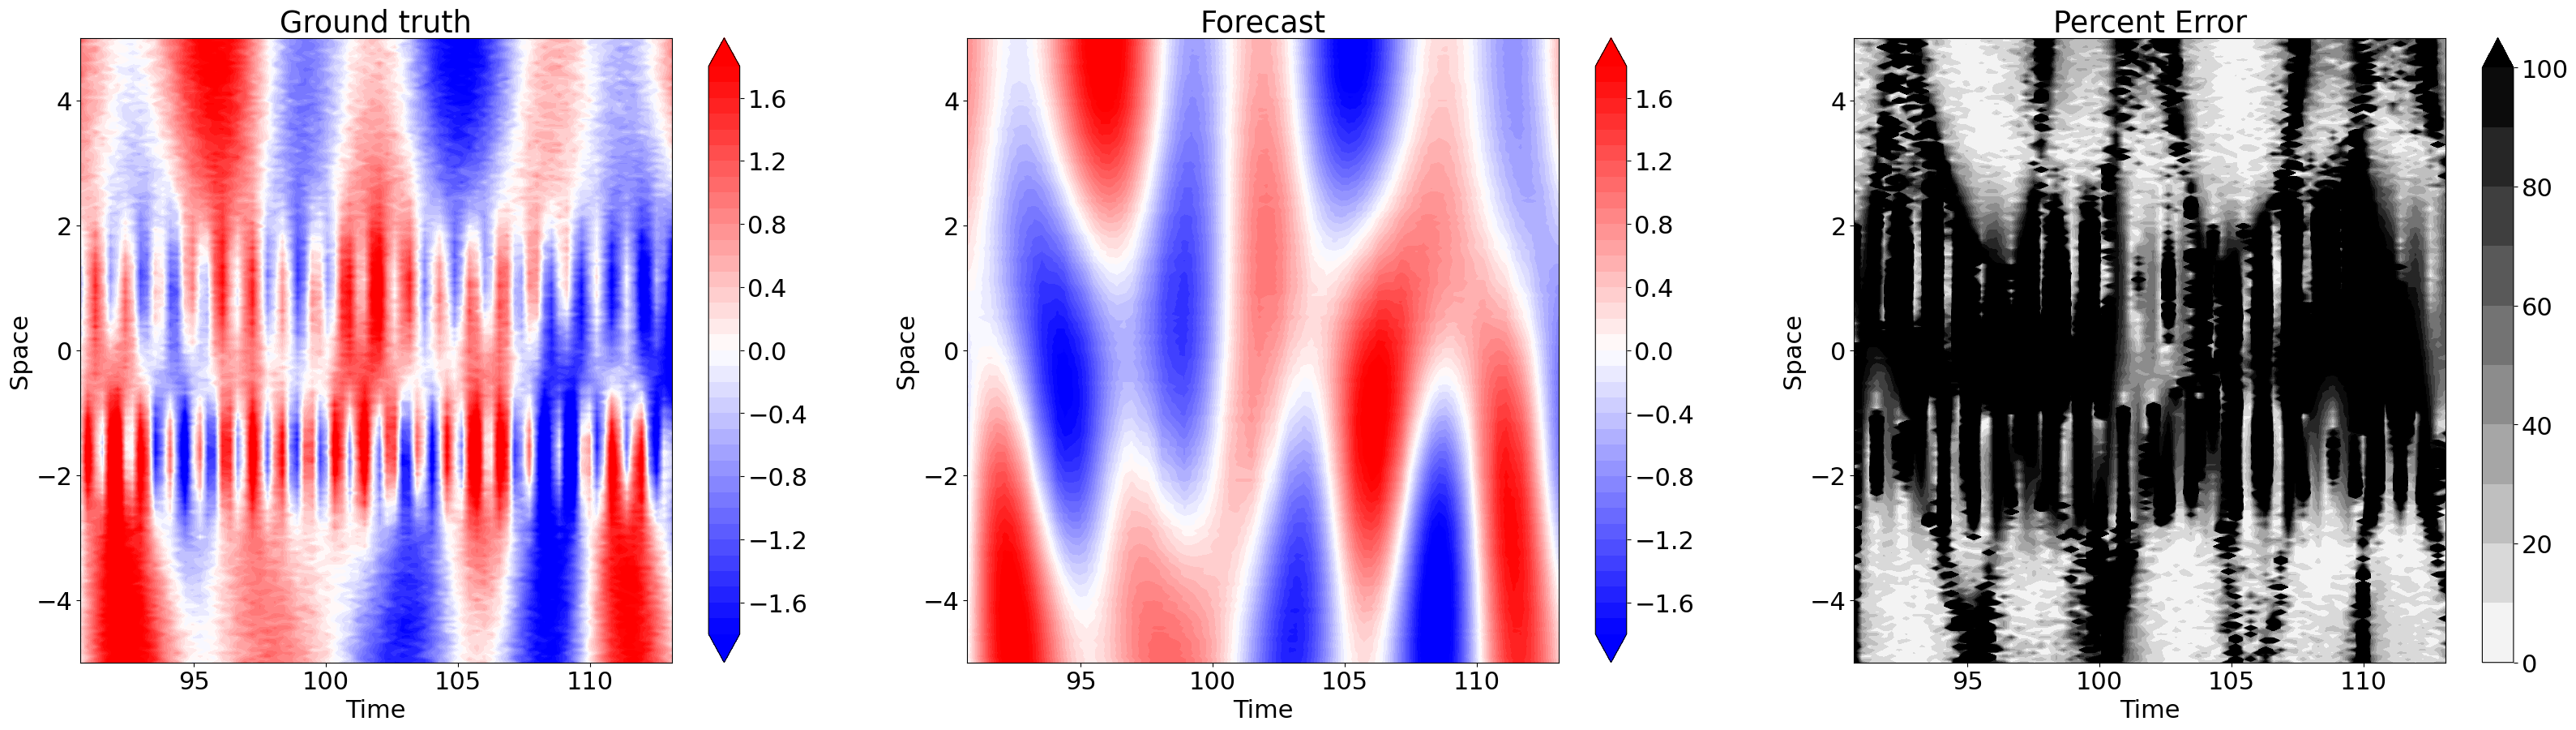

In [11]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.8; vmax = 1.8
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()

Perform optimized DMD with constraints.
Constrain to imaginary + conjugate, i.e. constrain eigenvalues to be purely imaginary and to always appear with their complex conjugate. This can be especially helpful for dealing with noise and preventing growth/decay of the modes.

In [12]:
optdmd = BOPDMD(svd_rank=svd_rank, num_trials=0, eig_constraints={"imag", "conjugate_pairs"})
delay_optdmd = hankel_preprocessing(optdmd, d=delay)
delay_optdmd.fit(f_train.T, t=t_delay)

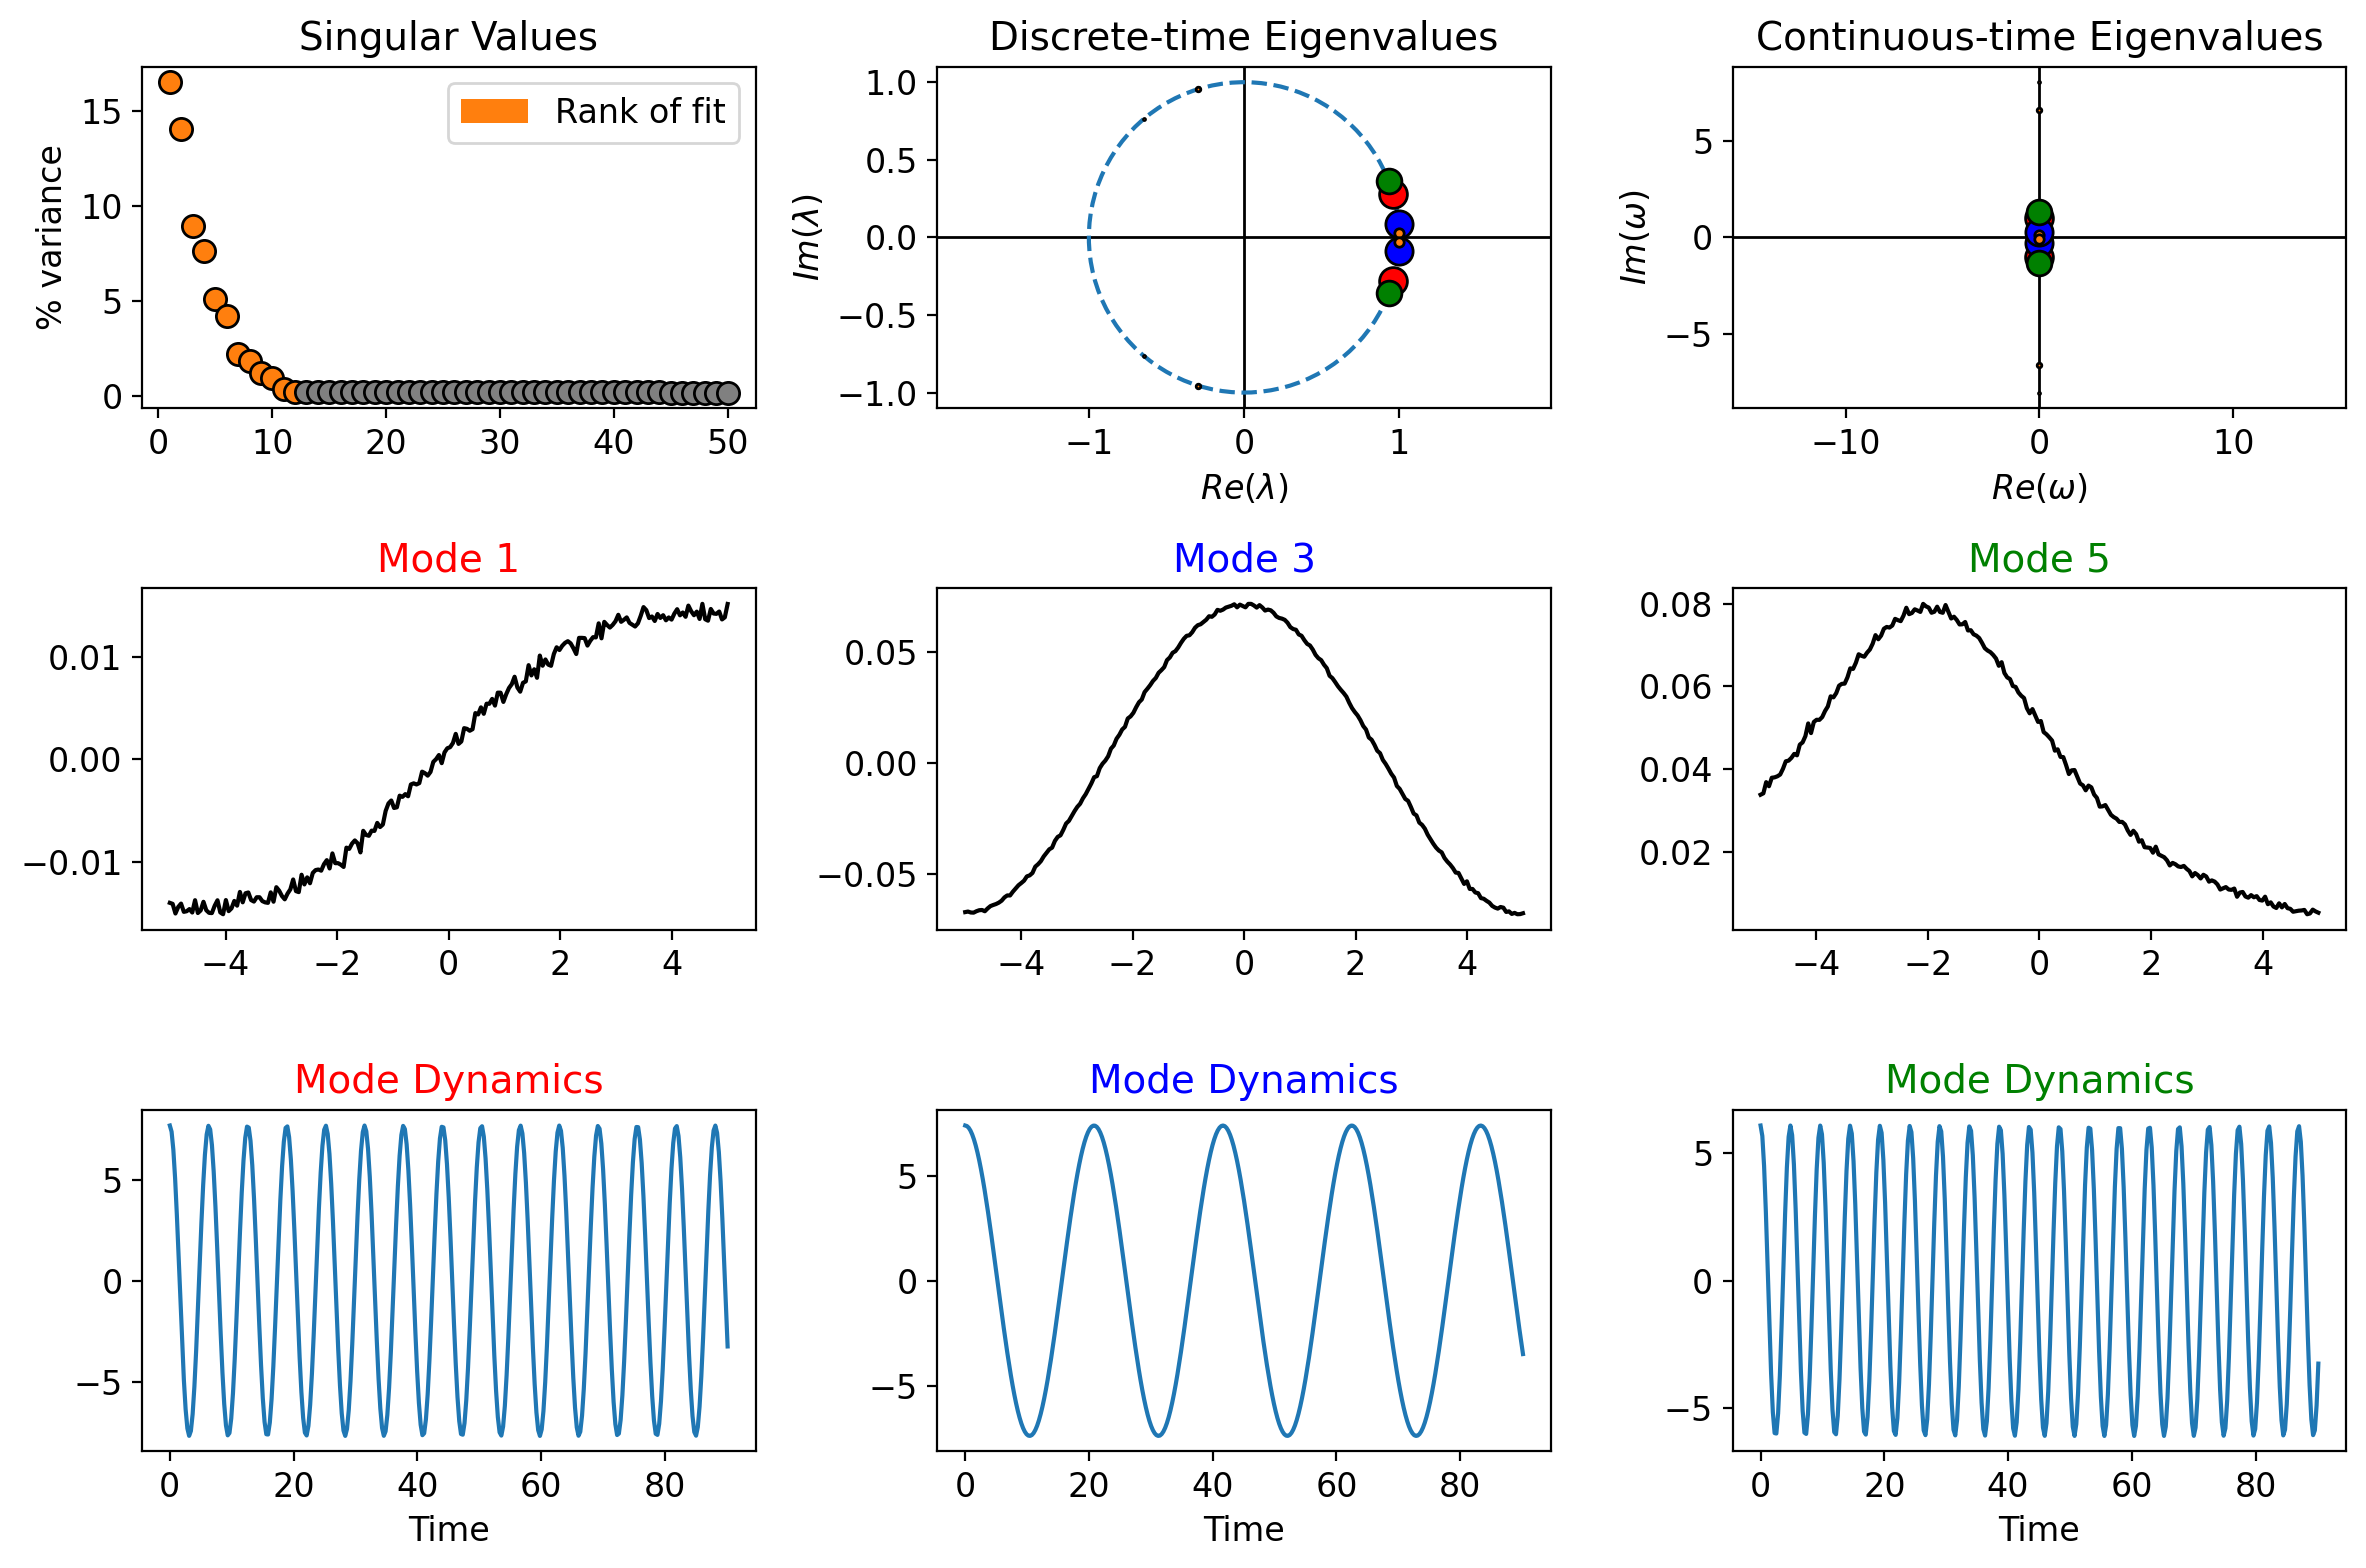

In [13]:
plt.rcParams.update({'font.size': 12})
plot_summary(delay_optdmd, x=signal_generator.x, d=delay, index_modes=[0, 2, 4])

In [14]:
# sort by decreasing amplitude
sorted_index = np.argsort(np.abs(delay_optdmd.amplitudes))[::-1]
delay_optdmd.eigs[sorted_index]

array([ 0.+0.99816791j, -0.-0.99816791j, -0.-0.30171149j,  0.+0.30171149j,
       -0.-1.30074556j,  0.+1.30074556j,  0.+0.10183264j, -0.-0.10183264j,
        0.+6.59665663j, -0.-6.59665663j,  0.+8.01163107j, -0.-8.01163107j])

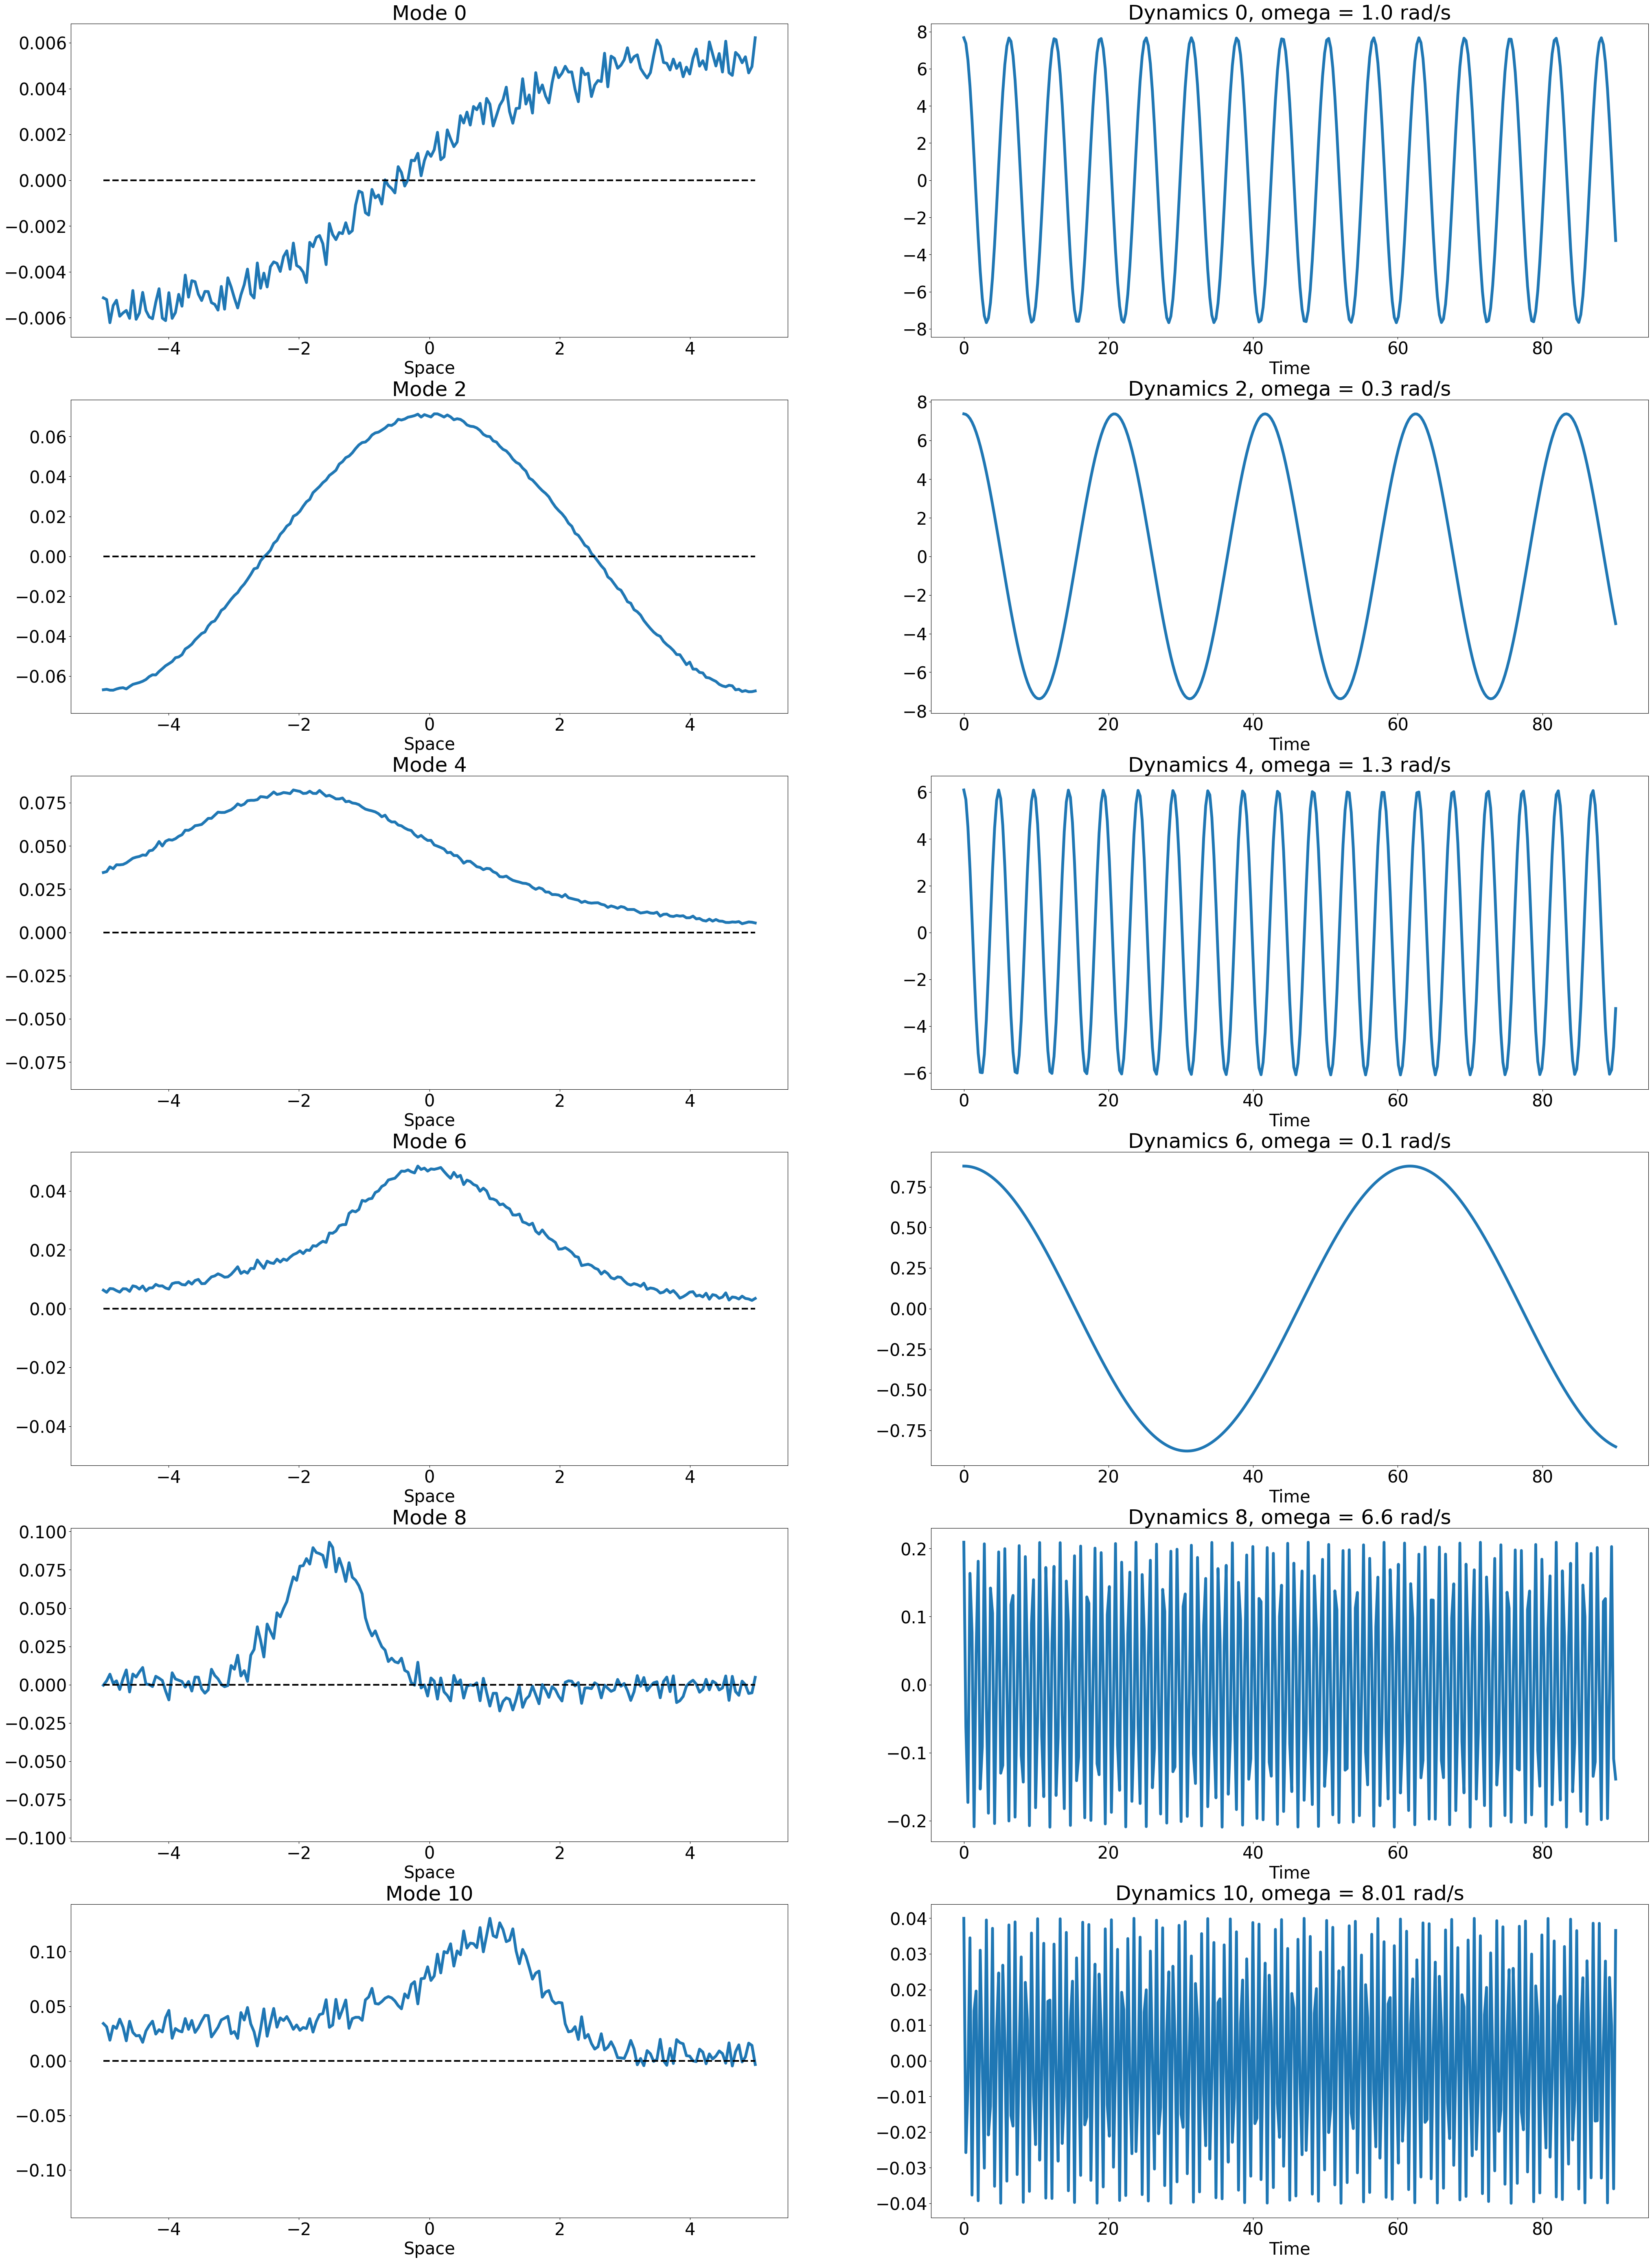

In [15]:
# plot the spatial modes and their dynamics

plt.rcParams.update({'font.size': 30})

which_modes = [0, 2, 4, 6, 8, 10]
fig, axs = plt.subplots(6, 2, figsize=(50, 70))
axs = axs.flatten()

eigs = delay_optdmd.eigs[sorted_index]
modes = delay_optdmd.modes[:, sorted_index]
dynamics = delay_optdmd.dynamics[sorted_index, :]

for i, mode in enumerate(which_modes):
    axs[2*i].plot(signal_generator.x, modes[:signal_generator.x.shape[0], mode].real, linewidth=5)
    axs[2*i].set_title(f'Mode {mode}')
    axs[2*i].set_xlabel('Space')
    max_val = np.max(np.abs(modes[:signal_generator.x.shape[0], mode].real))
    axs[2*i].set_ylim([-max_val*1.1, max_val*1.1])
    axs[2*i].hlines(0, signal_generator.x[0], signal_generator.x[-1], color='k', linestyle='--', linewidth=3)

    axs[2*i+1].plot(t_delay, dynamics[mode, :].real, linewidth=5)
    axs[2*i+1].set_title(f'Dynamics {mode}, omega = {np.round(np.abs(eigs[mode].imag), 2)} rad/s')
    axs[2*i+1].set_xlabel('Time')

plt.show()


Perform a forecast using the opt DMD model

In [16]:
forecast = delay_optdmd.forecast(t_test)
forecast = forecast[:signal_generator.x.shape[0], :]  # note than need to do this because of the time delay embedding
forecast = forecast.T
forecast = forecast.real

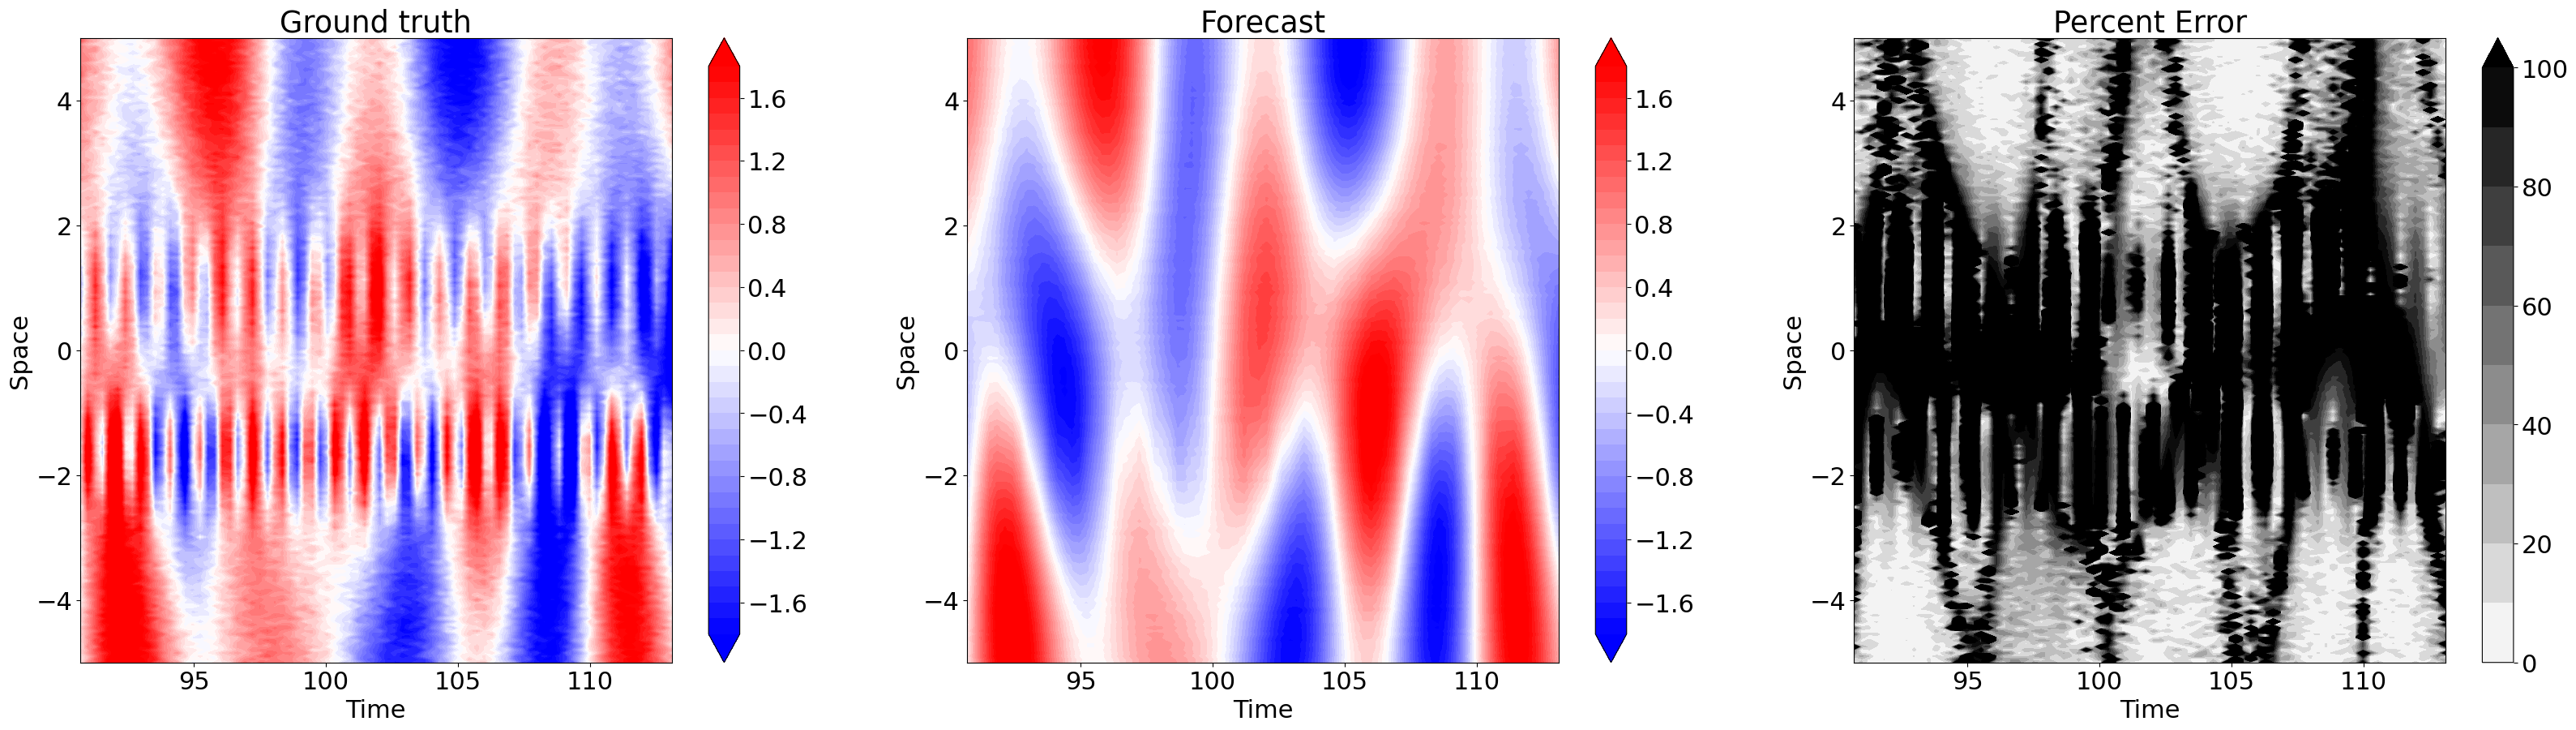

In [17]:
# compare the forecast to the ground truth

plt.rcParams.update({'font.size': 22})

X, T = np.meshgrid(signal_generator.x, t_test) 

fig = plt.figure(figsize=(40, 10))

vmin = -1.8; vmax = 1.8
levels = np.arange(vmin, vmax+0.1, 0.1)

ax = fig.add_subplot(1, 3, 1)
contour = ax.contourf(T, X, f_test, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title("Ground truth")
plt.colorbar(contour, ax=ax, orientation="vertical")

ax = fig.add_subplot(1, 3, 2)
contour = ax.contourf(T, X, forecast, levels=levels, cmap='bwr', extend="both")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Forecast')
plt.colorbar(contour, ax=ax, orientation="vertical")

# plot the percent error
percent_error = np.abs(f_test - forecast) / np.abs(f_test) * 100
ax = fig.add_subplot(1, 3, 3)
contour = ax.contourf(T, X, percent_error, levels=np.arange(0, 101, 10), cmap='gray_r', extend="max")
plt.xlabel('Time')
plt.ylabel('Space')
plt.title('Percent Error')
plt.colorbar(contour, ax=ax, orientation="vertical")

plt.show()